# Tuning

Tuning Trackers

Tuning the tracking model's hyperparameters is key to good performance. In SportsLabKit, we use the track-by-detection method. This includes a detection model, image model, and motion model, each with its own hyperparameters. These are different from the training parameters or weights. For example:

- Detection model: Image size is set to 640x480 pixels
- Image model: Image size is set to 800x600 pixels
- Motion model: Stride is set to 2 frames

You can fine-tune these hyperparameters with optimization methods like Covariance Matrix Adaptation Evolution Strategy (CMA-ES) and Tree-structured Parzen Estimator (TPE).

SportsLabKit provides functions to make tuning easier, which is important for better tracking performance. In this notebook, we'll learn how to use `tracker.tune_hparams()` and see how it improves the SORT Tracker.

In [1]:
%load_ext autoreload
%autoreload 2

## Prepare dataset

First, we'll prepare the dataset. To perform tuning we also need the ground truth tracking data.

In [2]:
import sportslabkit as slk
from sportslabkit.logger import set_log_level

dataset_path = slk.datasets.get_path("top_view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

root = slk.utils.get_git_root()
cam = slk.Camera(path_to_mp4)

# For the sake of speed, we'll only use the first 10 frames
n_frames = 100
frames = cam[:n_frames]

bbdf_gt = slk.load_df(path_to_csv)
# TODO: Hopefully we can get rid of this 
if bbdf_gt.index[0] == 0:
    bbdf_gt.index += 1
bbdf_gt = bbdf_gt[:n_frames]

## Prepare SORT Tracker

Next, we'll set up the tracker to be used, focusing on SORT, a simple yet effective Tracker in SportsLabKit. SORT relies on both a detection model and a motion model, each with specific configurations. Here are the details:

* **Detection Model - `YOLOv8x`**
    * `conf` - Confidence threshold for detecting objects (Default: 0.5)
    * `iou` - Intersection-over-Union threshold for suppressing duplicate detections (Default: 0.3)
    * `imgsz` - Image size to which the input is resized, affecting detection (Default: 2560x2560 pixels)


* **Motion Model - `KalmanFilterMotionModel`**
    * `dt` - Time step between consecutive measurements, crucial for predicting object position (Default: 1/30)
    * `process_noise` - Noise in the process model, representing uncertainty in motion prediction (Default: 1e-4)
    * `measurement_noise` - Noise in the measurements, representing sensor noise (Default: 1e-1)
    * `confidence_scaler` - Factor to scale the confidence in prediction, adjusting the influence of measurements vs predictions (Default: 0.5)

* **Tracking Algorithm - `SORTTracker`**
    * `metric` - The cost metric to use for assignment
    * `metric_gate` - The gate threshold for the cost metric
    * `t_lost` - The number of frames to wait before removing a track
    * `t_confirm` - The number of frames to wait before confirming a track

These configurations are essential in setting up the SORT Tracker, and the given defaults provide a good starting point. They can be tuned further as needed to align with the specific use case and environment.

In [3]:
from sportslabkit.mot import SORTTracker

slk.logger.set_log_level('INFO')
det_model = slk.detection_model.load(
    model_name='yolov8',
    model=root/'models/yolov8/soccer_top_view-model=yolov8x-imgsz=2048.pt',
    conf=0.25,
    iou=0.6,
    imgsz=2048,
    device=0,
    classes=0,
    augment=True,
    max_det=35
)

motion_model = slk.motion_model.load(
    model_name='kalmanfilter',
    dt=1/30,
    process_noise=500,
    measurement_noise=10,
    confidence_scaler=1
)

matching_fn = slk.matching.SimpleMatchingFunction(
    metric=slk.metrics.EuclideanCMM(use_pred_box=True),
    gate=0.5
)

tracker = SORTTracker(
    detection_model=det_model,
    motion_model=motion_model,
    matching_fn=matching_fn,
    max_staleness=20,
    min_length=20
)

## Tracking normally with SORT

In [4]:
from sportslabkit.metrics import hota_score

bbdf = tracker.track(frames)
score = hota_score(bboxes_track=bbdf, bboxes_gt=bbdf_gt)["HOTA"]

print(f'HOTA score: {score:.2f}')

Tracking Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Tracking Progress: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s, Active: 24, Dead: 2]


HOTA score: 0.67


In [5]:
bbdf.visualize_frames(cam.video_path, root/'notebooks/02_user_guide/assets/sort_not_tuned.mp4')

Writing video: 100it [00:10,  9.80it/s]


## Model Tuning

Each tunable component will have an associated class variable named `hparam_search_space`. This is a nested dictionary that contains key-value pairs in the format `param: {"type": "categorical", "values": list of possible values}` for a categorical search space, or `param: {"type": 'logfloat', "low": min value, "high": max value}` for a continuous search space.

For instance, a `KalmanFilterMotionModel` has the following hyperparameter search space:


In [6]:
slk.motion_model.KalmanFilter.hparam_search_space

{'dt': {'type': 'categorical',
  'values': [10,
   2,
   1,
   0.03333333333333333,
   0.016666666666666666,
   0.008333333333333333]},
 'process_noise': {'type': 'logfloat', 'low': 1e-06, 'high': 100.0},
 'measurement_noise': {'type': 'logfloat', 'low': 0.001, 'high': 100.0},
 'confidence_scaler': {'type': 'logfloat', 'low': 0.001, 'high': 100}}

We use [Optuna](https://optuna.org) to 

Each tracker object has a `tracker.create_hparam_dict()` method that generates a dictionary containing hyperparameter search spaces for each component. You can pass a dictionary into the `hparam_search_space` argument to overwrite the default search space. 

The `hparam_search_space` dictionary should be formatted as follows:

```
{
    'component name (motion_model/detection_model/image_model etc.)`: {
        'param name (imgsz/conf/t_lost etc.)': 
        {"type": 'logfloat', "low": min value, "high": max value} -> for continuous params
        or 
        {"type": 'categorical', "low": min value, "high": max value} -> for categorical params
    }
}
```


In [7]:
from sportslabkit.logger import logger
hparams = tracker.create_hparam_dict()
for attribute, param_space in hparams.items():
    logger.info(f"{attribute}:")
    for param_name, param_values in param_space.items():
        logger.info(f"\t{param_name}: {param_values}")


IPython:0004  💬| self: 
IPython:0006  💬| 	metric_gate: {'type': 'float', 'low': 0.01, 'high': 1} 
IPython:0006  💬| 	t_lost: {'type': 'int', 'low': 1, 'high': 1000.0} 
IPython:0004  💬| detection_model: 
IPython:0006  💬| 	max_det: {'type': 'int', 'values': None, 'low': 20, 'high': 50} 
IPython:0006  💬| 	imgsz: {'type': 'int', 'values': None, 'low': 1280, 'high': 3840} 
IPython:0006  💬| 	conf: {'type': 'float', 'values': None, 'low': 0.1, 'high': 1.0} 
IPython:0006  💬| 	iou: {'type': 'float', 'values': None, 'low': 0.1, 'high': 1.0} 
IPython:0004  💬| motion_model: 
IPython:0006  💬| 	dt: {'type': 'categorical', 'values': [10, 2, 1, 0.03333333333333333, 0.016666666666666666, 0.008333333333333333], 'low': None, 'high': None} 
IPython:0006  💬| 	process_noise: {'type': 'logfloat', 'values': None, 'low': 1e-06, 'high': 100.0} 
IPython:0006  💬| 	measurement_noise: {'type': 'logfloat', 'values': None, 'low': 0.001, 'high': 100.0} 
IPython:0006  💬| 	confidence_scaler: {'type': 'logfloat', 'values'

Define our own search space:

In [8]:
hparam_search_space = {
    'self': {
        'max_staleness': {'type': 'int', 'low': 10, 'high': 100},
        'min_length': {'type': 'int', 'low': 10, 'high': 100},
    },
    'motion_model':{
        'process_noise': {'type': 'float', 'low': 100,'high': 1000},
        'measurement_noise': {'type': 'float','low': 1,'high': 100},
        'confidence_scaler': {'type': 'logfloat','low': 1e-3, 'high': 1e3}
    },
    'detection_model':{
        "max_det": {"type": "int", "low": 20, "high": 50},
        "conf": {"type": "float", "low": 0.1, "high": .6},
        "iou": {"type": "float", "low": 0.3, "high": .5},
    },
    'matching_fn':{
        'gate': {'type': 'logfloat', 'low': 1e-4, 'high': 1}
    }
}

In [9]:
import optuna

sampler = optuna.samplers.CmaEsSampler()
pruner = optuna.pruners.HyperbandPruner()
best_params, best_hota, study = tracker.tune_hparams(
    frames_list=[frames],
    bbdf_gt_list=[bbdf_gt],
    n_trials=10,
    reuse_detections=False,
    hparam_search_space=hparam_search_space,
    verbose=True,
    sampler=sampler,
    pruner=pruner,
    return_study=True,
)

tune_hparams:0253  💬| Hyperparameter search space: 
tune_hparams:0255  💬| self: 
tune_hparams:0257  💬| 	max_staleness: {'type': 'int', 'low': 10, 'high': 100} 
tune_hparams:0257  💬| 	min_length: {'type': 'int', 'low': 10, 'high': 100} 
tune_hparams:0255  💬| motion_model: 
tune_hparams:0257  💬| 	process_noise: {'type': 'float', 'low': 100, 'high': 1000} 
tune_hparams:0257  💬| 	measurement_noise: {'type': 'float', 'low': 1, 'high': 100} 
tune_hparams:0257  💬| 	confidence_scaler: {'type': 'logfloat', 'low': 0.001, 'high': 1000.0} 
tune_hparams:0255  💬| detection_model: 
tune_hparams:0257  💬| 	max_det: {'type': 'int', 'low': 20, 'high': 50} 
tune_hparams:0257  💬| 	conf: {'type': 'float', 'low': 0.1, 'high': 0.6} 
tune_hparams:0257  💬| 	iou: {'type': 'float', 'low': 0.3, 'high': 0.5} 
tune_hparams:0255  💬| matching_fn: 
tune_hparams:0257  💬| 	gate: {'type': 'logfloat', 'low': 0.0001, 'high': 1} 


[I 2023-08-21 14:49:14,330] A new study created in memory with name: no-name-baffd161-43db-4814-8d65-dbed99038e62
Tracking Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Tracking Progress: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s, Active: 1704, Dead: 0]
[W 2023-08-21 14:49:59,072] Trial 0 failed with parameters: {'max_staleness': 81, 'min_length': 26, 'process_noise': 107.45501951679715, 'measurement_noise': 14.47835048351415, 'confidence_scaler': 20.61163322052972, 'max_det': 46, 'conf': 0.48191798620983384, 'iou': 0.46148564631937755, 'gate': 0.00021187769045602145} because of the following error: The value nan is not acceptable.
[W 2023-08-21 14:49:59,073] Trial 0 failed with value nan.
Tracking Progress: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s, Active: 22, Dead: 0]
[I 2023-08-21 14:50:33,332] Trial 1 finished with value: 0.672605557674046 and parameters: {'max_staleness': 79, 'min_length': 33, 'process_noise': 114.86857770421655, 'measurement_noise': 97.41671292185173, 'confidence_scaler': 14.990523117527346, 'max_det': 29, 'conf': 0.5964694336761054, 'iou': 0.30773303095524673, 'gate': 0.5593959171041554}. Best is trial 1 with val

In [10]:
print(f"Best HOTA: {best_hota}")
for key in best_params:
    print(f"{key}: {best_params[key]}")

Best HOTA: 0.7272012391795679
max_staleness: 70
min_length: 80
process_noise: 771.3671783689742
measurement_noise: 4.131281955898294
confidence_scaler: 0.10322804443222602
max_det: 37
conf: 0.41699959275723997
iou: 0.43222379993994675
gate: 0.026828469275201567


/tmp/40437371.1.gpu/ipykernel_3186863/1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

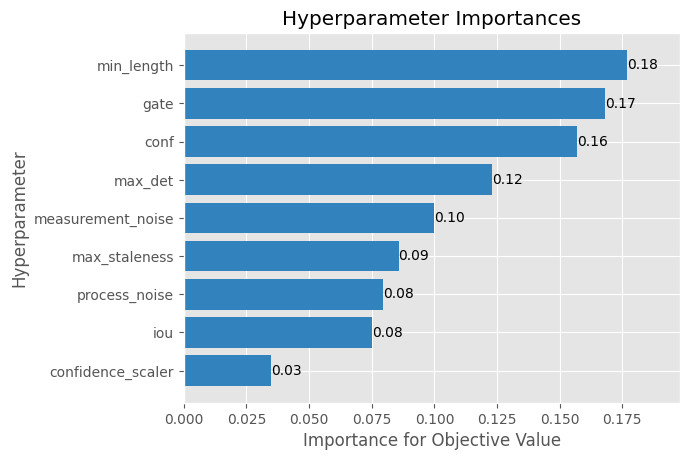

In [11]:
optuna.visualization.matplotlib.plot_param_importances(study)

/tmp/40437371.1.gpu/ipykernel_3186863/1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

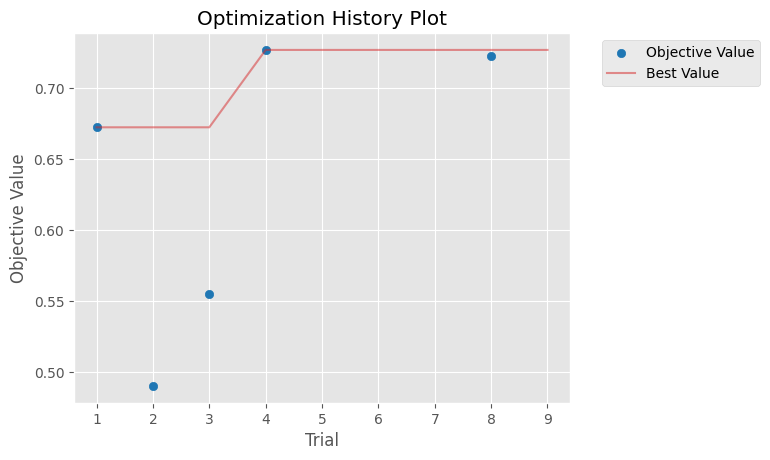

In [12]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [13]:
det_model = slk.detection_model.load(
    model_name='yolov8',
    model=root/'models/yolov8/soccer_top_view-model=yolov8x-imgsz=2048.pt',
    conf=best_params['conf'],
    iou=best_params['iou'],
    imgsz=2048,
    device=0,
    classes=0,
    augment=True,
    max_det=best_params['max_det'],
)

motion_model = slk.motion_model.load(
    model_name='kalmanfilter',
    dt=1/30,
    process_noise=best_params['process_noise'],
    measurement_noise=best_params['measurement_noise'],
    confidence_scaler=best_params['confidence_scaler'],
)

matching_fn = slk.matching.SimpleMatchingFunction(
    metric=slk.metrics.EuclideanCMM(use_pred_box=True),
    gate=best_params['gate'],
)

tracker = SORTTracker(
    detection_model=det_model,
    motion_model=motion_model,
    matching_fn=matching_fn,
    max_staleness=best_params['max_staleness'],
    min_length=best_params['min_length'],
)

bbdf = tracker.track(frames)
score = hota_score(bboxes_track=bbdf, bboxes_gt=bbdf_gt)["HOTA"]

print(f'HOTA score: {score:.2f}')
bbdf.visualize_frames(cam.video_path, root/'notebooks/02_user_guide/assets/sort_tuned.mp4')

Tracking Progress: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s, Active: 24, Dead: 0]


HOTA score: 0.73


Writing video: 100it [00:10,  9.90it/s]


In [14]:
hparam_search_space = {
    'self': {
        'max_staleness': {'type': 'int', 'low': 10, 'high': 100},
        'min_length': {'type': 'int', 'low': 10, 'high': 100},
    },
    'motion_model':{
        'process_noise': {'type': 'float', 'low': 100,'high': 1000},
        'measurement_noise': {'type': 'float','low': 1,'high': 100},
        'confidence_scaler': {'type': 'logfloat','low': 1e-3, 'high': 1e3}
    },
    'matching_fn':{
        'gate': {'type': 'logfloat', 'low': 1e-4, 'high': 1}
    }
}

sampler = optuna.samplers.CmaEsSampler()
pruner = optuna.pruners.HyperbandPruner()
best_params, best_hota, study = tracker.tune_hparams(
    frames_list=[frames],
    bbdf_gt_list=[bbdf_gt],
    n_trials=100,
    reuse_detections=True, # Changed to TRUE to reuse detections
    hparam_search_space=hparam_search_space,
    verbose=False, # Changed to False to quiet down the output
    sampler=sampler,
    pruner=pruner,
    return_study=True,
)
print(f"Best HOTA: {best_hota}")
for key in best_params:
    print(f"{key}: {best_params[key]}")

tune_hparams:0253  💬| Hyperparameter search space: 
tune_hparams:0255  💬| self: 
tune_hparams:0257  💬| 	max_staleness: {'type': 'int', 'low': 10, 'high': 100} 
tune_hparams:0257  💬| 	min_length: {'type': 'int', 'low': 10, 'high': 100} 
tune_hparams:0255  💬| motion_model: 
tune_hparams:0257  💬| 	process_noise: {'type': 'float', 'low': 100, 'high': 1000} 
tune_hparams:0257  💬| 	measurement_noise: {'type': 'float', 'low': 1, 'high': 100} 
tune_hparams:0257  💬| 	confidence_scaler: {'type': 'logfloat', 'low': 0.001, 'high': 1000.0} 
tune_hparams:0255  💬| matching_fn: 
tune_hparams:0257  💬| 	gate: {'type': 'logfloat', 'low': 0.0001, 'high': 1} 


Detecting frames for reuse:   0%|          | 0/100 [00:00<?, ?it/s]

Tracking Progress: 100%|██████████| 100/100 [00:06<00:00, 14.83it/s, Active: 1049, Dead: 0]
[W 2023-08-21 14:56:52,703] Trial 6 failed with parameters: {'max_staleness': 74, 'min_length': 59, 'process_noise': 595.8482788589121, 'measurement_noise': 56.546781660708405, 'confidence_scaler': 0.34673231514456454, 'gate': 0.001185062382405882} because of the following error: The value nan is not acceptable.
[W 2023-08-21 14:56:52,703] Trial 6 failed with value nan.
Tracking Progress: 100%|██████████| 100/100 [00:04<00:00, 23.92it/s, Active: 545, Dead: 0]
[W 2023-08-21 14:57:03,571] Trial 12 failed with parameters: {'max_staleness': 41, 'min_length': 53, 'process_noise': 488.7403304127384, 'measurement_noise': 48.68586516456558, 'confidence_scaler': 0.06020992490680793, 'gate': 0.0015571379456995045} because of the following error: The value nan is not acceptable.
[W 2023-08-21 14:57:03,572] Trial 12 failed with value nan.
Tracking Progress: 100%|██████████| 100/100 [00:05<00:00, 16.91it/s, 

Best HOTA: 0.7525460303046649
max_staleness: 98
min_length: 71
process_noise: 518.3539723369638
measurement_noise: 64.0411211460587
confidence_scaler: 17.218073222874676
gate: 0.1264365016741472
